## Descrição

- Treinar uma rede neural com 1 camada oculta e função de ativação tanh (tangente hiperbolica) usando algoritmo genetico e simulated annealing.
- tarefa: regressão de 1 variavel de entrada e 1 variavel de saida.
- funçao real: seno.
- Deve ser somado ruido Gaussiano aos pontos reais.
- conjunto de treino: pontos no intervalor -PI a PI.
- conjunto de teste: pontos no intervalor de 0 a 2 PI.
- Avaliar como o erro varia ao aumentar o numero de neuronios nos conjuntos de treino e teste.


## ENTREGAR
Devem ser entregues os códigos-fontes e um relatório que apresente e discuta, para cada algoritmo (GA e Simulated Annealing), os artefatos abaixo:
- tabela com erro para rede com 2,4,8,16,32,64,128 neuronios (Num neuronios | erro treino | erro teste) <font color='green'>Done</font>
- Grafico de evoluçao da fitness (erro no treino) para cada configuraçao <font color='green'>Done</font>
- Grafico da funçao final para cada configuraçao. <font color='green'>Done</font>

## Pontos Extras
- Implementar o método de descida do gradiente (Gradient Descent) e comparar com as metaheurísticas: +5 pontos. <font color='Red'>NOT DONE - n sei fazer </font>
- Implementar o código de forma que seja possível usar facilmente diferentes números de entradas, saídas e números de camadas: +5 pontos. <font color='green'>DONE - so precisa comentar a tabelaNeural com campos internos </font>
- Realizar testes com outras funções além da função seno (pelo menos outras 2): +2 pontos. <font color='green'>DONE - esta na funçao true_regression_fn, é so escolher qual retorno que voce quer </font>

In [1]:
##FUNÇÕES 

def true_regression_fn(x): # troca pra coseno dps tangente
    return np.sin(x) + np.random.normal(loc=0.0, scale = 0.1)
#     return (x ** 2) + 5 * np.sin(5 * x) # complexa o suficiente para nao precisar de ruido
#     return np.power((x/3),2) + np.random.normal(loc=0.0, scale = 0.1)

def calculaRMSE(TREINO_ESCOPO,RESP_regression,rede):
    
    y_pred = []
    y = RESP_regression
    for input in TREINO_ESCOPO:
        data = processNN([input],rede)[0] # ja que é uma entrada e uma saida por isso do [0]
#         print(data)
        y_pred.append(data)
    
#     print("y_pred:",len(y_pred))
#     print("y:",len(y))

    error = np.subtract(y,y_pred)
    
#     print(error)
    return np.sqrt(np.mean(np.square(error)))
    

def processNN(entrada,rede):
    activations = []
    for l in rede:
        activations.append(l.forward(entrada))
        entrada = activations[-1]
    return entrada

def plot_fn(true_regression_fn, search_space, step=0.1):
    # plt.clf()
    x = np.arange(search_space[0], search_space[1], step)
    y = np.array(list(map(true_regression_fn, x)))
    plt.plot(x, y, label = "regression_fn")

In [2]:
## NN

class Camada():
    def __init__(self, input_units, output_units):
        # iniciando os pesos "aleatoriamente" (matriz)
        self.weights = np.random.uniform(low=SEARCH_SPACE[0], high = SEARCH_SPACE[1], size = (input_units,output_units))
        self.biases = np.random.uniform(low=SEARCH_SPACE[0], high = SEARCH_SPACE[1], size = output_units)
#         self.weights = np.zeros((input_units,output_units))
#         self.biases = np.zeros(output_units)
        #print("peso:",self.weights)
        #print("bias:",self.biases)
        
    def forward(self,inpt):
        # multiplicando o input com os pesos depois somando a bias + calculando o tanh
        dot = np.dot(inpt,self.weights)
        sum = dot + self.biases
        tanh = np.tanh(sum)
#         print("inpt:",inpt)
#         print("dot:",dot)
#         print("sum:",sum)
#         print("tanh:",tanh)
#         print("\n")
        
        return tanh #checar se o tamanho da matriz ta saindo correto


In [3]:
## SIMULATED ANNEALING
class SimulatedAnnealing():
    
    def __init__(self,search_space, DESVIO_PADRAO, temperature, alpha, num_vizinhos):
        self.search_space = search_space
        self.DESVIO_PADRAO = DESVIO_PADRAO
        self.temperature = temperature
        self.alpha = alpha
        self.num_vizinhos = num_vizinhos

    def gera_vizinhos(self,solucao):
        vizinhos = []
        
        for _ in range(self.num_vizinhos):

            #condiçao de mutaçao
            if random.uniform(0,1) <= 0.5:
                vizinho = solucao + np.random.normal(loc=0, scale=self.DESVIO_PADRAO)
                #adiciona gaussiana no dado

                # basicamente vai pegar outro vizinho enquanto estiver fora do espaço de busca
                while vizinho < self.search_space[0] or vizinho > self.search_space[1]:
                    if vizinho < self.search_space[0]:
                        ruido = abs(np.random.normal(loc=0, scale=self.DESVIO_PADRAO))
                    if vizinho > self.search_space[1]:
                        ruido = -abs(np.random.normal(loc=0, scale=self.DESVIO_PADRAO))
                    vizinho = solucao + ruido
            else:
                vizinho = random.uniform(self.search_space[0], self.search_space[1])
                #muda o dado para um valor aleatorio dentro do espaço de busca
            
            vizinhos.append(vizinho)

        return vizinhos
    
    def atTemperature(self):
        self.temperature *= self.alpha
        return self.temperature

In [4]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display
import tqdm
from copy import deepcopy

%matplotlib inline

N_POPULACAO = 50 #50
N_INTERACAO = 2000 #2000
# np.random.seed(0)
PI = np.pi
SEARCH_SPACE = [-5,5] #espaço de operaçao
TRAINING_SPACE = [-PI,PI] #espaço de treino

TESTE_ESCOPO = [] # escopo de entradas de teste da rede
aux = -2*PI
while aux <= 2*PI:
    TESTE_ESCOPO.append(aux)
    aux += 0.2

TREINO_ESCOPO = []
aux = TRAINING_SPACE[0]
for _ in range(32):
    TREINO_ESCOPO.append(aux)
    aux += 0.2
    
DESVIO_PADRAO = 0.3

RESP_regression = []
for x in TREINO_ESCOPO:
    RESP_regression.append(true_regression_fn(x))
    
RESP_regression_teste = []
for x in TESTE_ESCOPO:
    RESP_regression_teste.append(true_regression_fn(x))
            
tabelaRmse = []

In [ ]:
## MAIN SA
tabelaRmse = []
def mainSA():
    
    # caso precise criar uma rede com varias entradas
#     entrada = [] # entrada varios valores
#     aux = -3
#     for _ in range(6):
#         entrada.append(aux)
#         aux += 1
    
    
    entrada = [0]

        
    RESP_regression = []
    for x in TREINO_ESCOPO:
        RESP_regression.append(true_regression_fn(x))
    
    
    tabelaNeural = [0]
    tabelaNeural = [2,4,8,16,32,64,128] # comenta essa linha para ativar o modo criar sua rede
    
    for tn in range(len(tabelaNeural)):
        rede = []
        RMSEs = []
        inLayer = len(entrada)
        if len(tabelaNeural) == 1:
            print("Quantas camadas você deseja que a rede tenha?")
            camadas = int(input()) # quantas camadas vc quer
            for i in range(camadas):
                print("Quantos neuronios na camada",i,"voce deseja?")
                outLayer = int(input()) # quantos neuronios vc quer
                rede.append(Camada(inLayer,outLayer))
                inLayer = outLayer
        else:
            camadas = 1    
            for i in range(camadas):
                outLayer = tabelaNeural[tn]
                rede.append(Camada(inLayer,outLayer))
                inLayer = outLayer
            print("EXECUTANDO TABELA NEURAL [ INTERACAO:",tn,"NEURONIOS:",tabelaNeural[tn],"]")
        rede.append(Camada(inLayer,len(entrada)))

        rmse = calculaRMSE(TREINO_ESCOPO,RESP_regression,rede)

        RMSEs.append(rmse)

        print("RMSE virgem:",rmse)        

        SA = SimulatedAnnealing(search_space = SEARCH_SPACE, # espaço de treino da rede
                                DESVIO_PADRAO = 0.3,
                                temperature = 100,
                                alpha = 0.995,
                                num_vizinhos = 1)

        # modificando um dado da rede para calcular o novo RMSE se ele melhora atualiza a rede, se nao vai para proxima interacao
        for p in tqdm.tqdm(range(N_POPULACAO*N_INTERACAO)):
            # extraindo ids da rede
            layerId = np.random.randint(len(rede))
            weighId = np.random.randint(len(rede[layerId].weights))
            neuroId = np.random.randint(len(rede[layerId].weights[weighId]))

#             print("camada[{}/{}], peso[{}/{}], neuronio[{}/{}] ".format(len(rede),layerId,len(rede[layerId].weights),weighId,len(rede[layerId].weights[weighId]),neuroId))
            
            # extraindo peso e bias
            peso = rede[layerId].weights[weighId][neuroId]
            bias = rede[layerId].biases[neuroId]

            # filtro para mudar Peso ou Bias
            if random.uniform(0,1) <= 0.5:
                isPeso = True
                data = peso
            else:
                isPeso = False
                data = bias
            
            vizinhos = SA.gera_vizinhos(data)
            for data_vizinha in vizinhos:
                newRede = deepcopy(rede)

                if isPeso:
                    newRede[layerId].weights[weighId][neuroId] = data_vizinha
                else:
                    newRede[layerId].biases[neuroId] = data_vizinha

                newRMSE = calculaRMSE(TREINO_ESCOPO,RESP_regression,newRede)

                if newRMSE < rmse:
                    rmse = newRMSE # RMSE da nova  rede
                    rede = newRede # nova rede

                else:  # data_vizinha eh pior (delta >= 0)
                    delta = rmse - newRMSE
                    prob_aceitacao = np.exp(delta / SA.temperature)
                    if random.uniform(0, 1) < prob_aceitacao:
                        # data_vizinha eh aceito mesmo sendo pior.
                        rmse = newRMSE # RMSE da nova  rede
                        rede = newRede # nova rede
                
                SA.atTemperature()
                RMSEs.append(rmse)


        print("RMSE Final:", rmse)
        
        resultado_teste = []

        resultado_treino=[]
        for te in TREINO_ESCOPO:
            resultado_treino.append(processNN([te],rede)[0])
        
        for te in TESTE_ESCOPO:
            resultado_teste.append(processNN([te],rede)[0])
        
        rmseTeste = calculaRMSE(TESTE_ESCOPO,RESP_regression_teste,rede)
            
    
        # adiciona o Rmse final a tabela 
        tabelaRmse.append([tabelaNeural[tn], rmse,rmseTeste])
        
        
        # plota o conjunto de treinamento + conjunto de teste
        figure= plt.subplots(figsize=(10, 8))
        plt.title("RMSE", fontsize=20)
        plt.xlabel("interacoes")
        plt.ylabel("Fo")
        plt.subplot(2, 1, 1)
        plt.cla()
        plot_fn(true_regression_fn, SEARCH_SPACE)
        plot_teste = plt.plot(TESTE_ESCOPO, resultado_teste,color='tab:green', markersize=7, label="teste") # resposta da rede com o escopo de teste
        plot_treino = plt.plot(TREINO_ESCOPO, resultado_treino,'*r', markersize=7, label = "treino") # resposta da rede com o escopo de treino
        plt.legend(loc ="upper right")
        plt.title("X and predicted Y - Neuronios: "+str(tabelaNeural[tn]))
        

        plt.subplot(2, 1, 2)
        # plta o avanço do rmse 
        plt.title("RMSEs")
        plt.plot(RMSEs)
        plt.show()

        
    #printa a tabela
    print("TABELA DE RMSEs")
    print(pd.DataFrame(tabelaRmse, columns=["qntNeuronios", "rmseTreino", "rmseTeste"]))
    
    
if __name__ == "__main__":
    mainSA()

### ALGORITMO GENETICO

Passos:
Cria-se uma populaçao de 50 individuo (vetor de individuos criado)
- cada individuo tem seu gene, seu gene é a rede neural vetorizada
- calcula-se sua aptidão, seria o resultado da rede calculando o RMSE

Inicia-se um loop para cada individuo da populaçao: (isso representa uma geraçao)
- Elitismo, escolhe o melhor individuo (o que possui a melhor aptidao), reservo-o para o final
- Torneio, duelo entre 2 pessoas aleatorios e o mais forte vence é separado para cruzar com outro que vencer o duelo tambem.
- - CrossOver, Misturo os genes de 2 individuos vencedores do duelo, gerando uma nova populaçao que serao os filhos
- Mutaçao, (10%), individuo selecionado seu genes sao randomizados no intervalo (50%), ou adiciona-se um ruido no gene (gene é a rede neural)
- - Na mutação, cada filho tem 10% de chance de mutar. A mutação é igual no SA. Um peso ou bias aleatório do indivíduo é transformado (nota que não são todos os números, é 1 só).
- calculo aptidao, calculo o RMSE de todos os individuos (rodo a rede que eles carregam e vejo o resultado no RMSE)
- add Elite, em toda populaçao procuro o PIOR individuo e substituo-o pelo elite do inicio do loop

Repete-se o loop de cima 2000x que é o total de geraçoes percorridas

100%|██████████| 50/50 [00:00<00:00, 1087.01it/s]


first elite: 0.3852432333139307


  0%|          | 1/2000 [00:00<03:27,  9.62it/s]

0.3767422892606325 < 0.3852432333139307


  0%|          | 3/2000 [00:00<03:08, 10.59it/s]

0.272035678318699 < 0.3767422892606325


  0%|          | 9/2000 [00:00<02:22, 14.00it/s]

0.2694333290699025 < 0.272035678318699


  1%|          | 11/2000 [00:00<02:13, 14.87it/s]

0.2613226134419197 < 0.2694333290699025


  3%|▎         | 59/2000 [00:03<01:33, 20.83it/s]

0.2613222903653806 < 0.2613226134419197


  3%|▎         | 64/2000 [00:03<01:40, 19.32it/s]

0.2594550642078638 < 0.2613222903653806


  3%|▎         | 66/2000 [00:03<01:40, 19.23it/s]

0.25909754156806075 < 0.2594550642078638
0.25786990077964084 < 0.25909754156806075


  4%|▍         | 77/2000 [00:04<01:41, 18.90it/s]

0.2578607614479187 < 0.25786990077964084


  6%|▌         | 115/2000 [00:06<01:52, 16.73it/s]

0.249125059078826 < 0.2578607614479187


  6%|▌         | 117/2000 [00:06<01:47, 17.47it/s]

0.2485217288960193 < 0.249125059078826


  7%|▋         | 136/2000 [00:07<01:32, 20.08it/s]

0.24851611088280676 < 0.2485217288960193


 20%|█▉        | 396/2000 [00:21<01:11, 22.35it/s]

0.2451320548625005 < 0.24851611088280676
0.24429199777062913 < 0.2451320548625005


 20%|█▉        | 399/2000 [00:21<01:20, 19.91it/s]

0.24411826979871384 < 0.24429199777062913
0.24405330265235078 < 0.24411826979871384
0.24404776356657523 < 0.24405330265235078


 20%|██        | 402/2000 [00:21<01:28, 18.10it/s]

0.24394700394305263 < 0.24404776356657523


 20%|██        | 404/2000 [00:21<01:36, 16.51it/s]

0.24394535800264777 < 0.24394700394305263


 35%|███▌      | 705/2000 [00:35<01:06, 19.42it/s]

0.24303330189264286 < 0.24394535800264777


 43%|████▎     | 852/2000 [00:43<00:54, 20.88it/s]

0.24303330189264283 < 0.24303330189264286


 51%|█████     | 1017/2000 [00:50<00:44, 22.30it/s]

0.24303070163316248 < 0.24303330189264283


 51%|█████     | 1020/2000 [00:50<00:43, 22.34it/s]

0.24289721450620647 < 0.24303070163316248
0.2428581984114183 < 0.24289721450620647


 51%|█████     | 1023/2000 [00:50<00:52, 18.57it/s]

0.24285729808101447 < 0.2428581984114183
0.2428472883988347 < 0.24285729808101447


 58%|█████▊    | 1169/2000 [00:57<00:47, 17.59it/s]

0.24284728839883468 < 0.2428472883988347


 60%|█████▉    | 1195/2000 [00:59<00:39, 20.25it/s]

0.24092249307043206 < 0.24284728839883468
0.24082197690621968 < 0.24092249307043206


 60%|██████    | 1203/2000 [00:59<00:42, 18.84it/s]

0.24081137095934035 < 0.24082197690621968


 60%|██████    | 1205/2000 [00:59<00:42, 18.71it/s]

0.240798940313569 < 0.24081137095934035


 60%|██████    | 1207/2000 [00:59<00:44, 17.66it/s]

0.24078631159368263 < 0.240798940313569


 64%|██████▍   | 1276/2000 [01:03<00:32, 21.99it/s]

0.24034132007224626 < 0.24078631159368263


 64%|██████▍   | 1279/2000 [01:03<00:33, 21.71it/s]

0.2402799714233594 < 0.24034132007224626
0.24026965855742388 < 0.2402799714233594
0.24026557308735963 < 0.24026965855742388


 64%|██████▍   | 1282/2000 [01:03<00:41, 17.14it/s]

0.24025122345943237 < 0.24026557308735963


 73%|███████▎  | 1451/2000 [01:11<00:24, 22.58it/s]

0.24020862132828827 < 0.24025122345943237


 81%|████████  | 1618/2000 [01:19<00:18, 21.00it/s]

0.23792875216584536 < 0.24020862132828827


 81%|████████  | 1621/2000 [01:19<00:19, 19.71it/s]

0.23783435584306498 < 0.23792875216584536


 82%|████████▏ | 1634/2000 [01:20<00:17, 20.95it/s]

0.2378306208458476 < 0.23783435584306498


 89%|████████▉ | 1775/2000 [01:26<00:10, 22.15it/s]

0.23783062084584755 < 0.2378306208458476


 89%|████████▉ | 1787/2000 [01:27<00:09, 21.50it/s]

0.23783062084584752 < 0.23783062084584755


 94%|█████████▍| 1889/2000 [01:32<00:04, 22.73it/s]

0.23706090024347537 < 0.23783062084584752


 95%|█████████▍| 1892/2000 [01:32<00:04, 21.81it/s]

0.23679708192231386 < 0.23706090024347537
0.23673277930720296 < 0.23679708192231386


100%|██████████| 2000/2000 [01:37<00:00, 20.54it/s]


rmse Elite: 0.23673277930720296


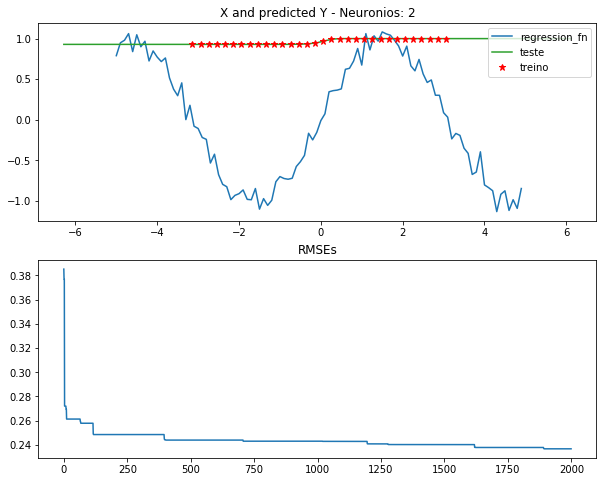

100%|██████████| 50/50 [00:00<00:00, 1893.27it/s]


first elite: 0.40704331137802396


  0%|          | 0/2000 [00:00<?, ?it/s]

0.3801403707598595 < 0.40704331137802396


  0%|          | 2/2000 [00:00<01:50, 18.02it/s]

0.347870363001879 < 0.3801403707598595


  0%|          | 4/2000 [00:00<01:59, 16.67it/s]

0.3062647379682299 < 0.347870363001879


  0%|          | 8/2000 [00:00<02:07, 15.64it/s]

0.29733607163869924 < 0.3062647379682299


  0%|          | 10/2000 [00:00<02:10, 15.24it/s]

0.2944353579764946 < 0.29733607163869924


  1%|          | 12/2000 [00:00<02:06, 15.68it/s]

0.2940065043906372 < 0.2944353579764946


  1%|          | 18/2000 [00:01<01:58, 16.74it/s]

0.2937161260577295 < 0.2940065043906372


  6%|▋         | 127/2000 [00:06<01:42, 18.22it/s]

0.29129865585108267 < 0.2937161260577295
0.2886755349918504 < 0.29129865585108267


  7%|▋         | 138/2000 [00:07<01:39, 18.74it/s]

0.28864072754748765 < 0.2886755349918504


  8%|▊         | 158/2000 [00:08<02:07, 14.49it/s]

0.28864060790547935 < 0.28864072754748765


 15%|█▍        | 298/2000 [00:15<01:19, 21.29it/s]

0.28863147683999474 < 0.28864060790547935


 17%|█▋        | 334/2000 [00:17<01:15, 21.97it/s]

0.27123350510725974 < 0.28863147683999474


 17%|█▋        | 337/2000 [00:17<01:18, 21.32it/s]

0.2576436228908269 < 0.27123350510725974


 17%|█▋        | 340/2000 [00:17<01:25, 19.52it/s]

0.25612798434351686 < 0.2576436228908269


 18%|█▊        | 356/2000 [00:18<01:23, 19.64it/s]

0.25611976694045835 < 0.25612798434351686


 21%|██        | 416/2000 [00:21<01:13, 21.47it/s]

0.2504914390434564 < 0.25611976694045835
0.2476350999021252 < 0.2504914390434564


 21%|██        | 423/2000 [00:21<01:24, 18.70it/s]

0.24762542633958945 < 0.2476350999021252


 29%|██▉       | 575/2000 [00:29<01:07, 21.21it/s]

0.24762542633958942 < 0.24762542633958945


 29%|██▉       | 584/2000 [00:29<01:10, 20.07it/s]

0.2476254263395894 < 0.24762542633958942


 30%|██▉       | 590/2000 [00:30<01:12, 19.52it/s]

0.24762542633958937 < 0.2476254263395894


 31%|███       | 621/2000 [00:31<01:04, 21.29it/s]

0.24762542633958934 < 0.24762542633958937


 32%|███▏      | 630/2000 [00:32<01:05, 20.86it/s]

0.24758990742537237 < 0.24762542633958934


 32%|███▏      | 633/2000 [00:32<01:04, 21.32it/s]

0.23945339113189465 < 0.24758990742537237


 32%|███▏      | 636/2000 [00:32<01:08, 19.79it/s]

0.2394440402631557 < 0.23945339113189465


 32%|███▏      | 639/2000 [00:32<01:08, 19.81it/s]

0.2394238954936249 < 0.2394440402631557


 39%|███▊      | 773/2000 [00:38<00:58, 21.11it/s]

0.23942389549362486 < 0.2394238954936249


 39%|███▉      | 787/2000 [00:39<01:10, 17.27it/s]

0.23942389549362483 < 0.23942389549362486


 45%|████▍     | 892/2000 [00:44<00:54, 20.46it/s]

0.2373356019383034 < 0.23942389549362483


 45%|████▍     | 895/2000 [00:44<00:52, 20.93it/s]

0.2370573022498453 < 0.2373356019383034


 45%|████▌     | 900/2000 [00:45<00:57, 19.00it/s]

0.2370275974879102 < 0.2370573022498453


 45%|████▌     | 906/2000 [00:45<01:01, 17.80it/s]

0.23701821851268257 < 0.2370275974879102


 45%|████▌     | 909/2000 [00:45<00:58, 18.50it/s]

0.23700901562267504 < 0.23701821851268257


 54%|█████▎    | 1071/2000 [00:53<00:42, 22.09it/s]

0.237009015622675 < 0.23700901562267504


 55%|█████▌    | 1107/2000 [00:54<00:41, 21.51it/s]

0.23631059081208455 < 0.237009015622675


 62%|██████▏   | 1241/2000 [01:01<00:35, 21.16it/s]

0.23631059081208453 < 0.23631059081208455


 63%|██████▎   | 1264/2000 [01:02<00:47, 15.62it/s]

0.2363105908120845 < 0.23631059081208453


 69%|██████▉   | 1379/2000 [01:09<00:48, 12.71it/s]

0.2338961757618398 < 0.2363105908120845
0.23349476180880083 < 0.2338961757618398


 69%|██████▉   | 1381/2000 [01:09<00:52, 11.78it/s]

0.23344957189346668 < 0.23349476180880083


 84%|████████▍ | 1687/2000 [01:29<00:14, 21.66it/s]

0.23341466857433255 < 0.23344957189346668
0.23341057503860738 < 0.23341466857433255


 85%|████████▍ | 1692/2000 [01:30<00:16, 18.33it/s]

0.2334082444973729 < 0.23341057503860738


 98%|█████████▊| 1970/2000 [01:43<00:01, 18.46it/s]

0.2329266961667444 < 0.2334082444973729
0.23278541099106048 < 0.2329266961667444


 99%|█████████▊| 1972/2000 [01:43<00:01, 14.63it/s]

0.23277402499936267 < 0.23278541099106048
0.2327662196367324 < 0.23277402499936267


100%|██████████| 2000/2000 [01:45<00:00, 18.97it/s]


rmse Elite: 0.2327662196367324


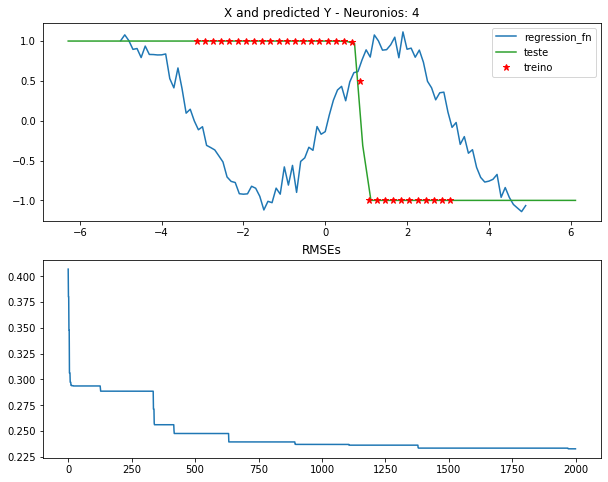

100%|██████████| 50/50 [00:00<00:00, 2499.59it/s]


first elite: 0.40707194521659523


  0%|          | 2/2000 [00:00<02:01, 16.39it/s]

0.3892210316495312 < 0.40707194521659523


  0%|          | 4/2000 [00:00<01:57, 17.00it/s]

0.3561141574673231 < 0.3892210316495312


  0%|          | 6/2000 [00:00<02:09, 15.38it/s]

0.33156451021976535 < 0.3561141574673231
0.32381148774745266 < 0.33156451021976535


  0%|          | 8/2000 [00:00<02:23, 13.91it/s]

0.3181166770159171 < 0.32381148774745266
0.3092627595539556 < 0.3181166770159171


  0%|          | 10/2000 [00:00<02:34, 12.91it/s]

0.303966687435543 < 0.3092627595539556


  1%|          | 12/2000 [00:00<02:34, 12.85it/s]

0.3032711564765556 < 0.303966687435543
0.2995064347351678 < 0.3032711564765556


  1%|          | 14/2000 [00:01<02:30, 13.20it/s]

0.2992403328572465 < 0.2995064347351678


  2%|▏         | 41/2000 [00:02<01:31, 21.52it/s]

0.228504831616666 < 0.2992403328572465


100%|██████████| 2000/2000 [01:51<00:00, 17.87it/s]


rmse Elite: 0.228504831616666


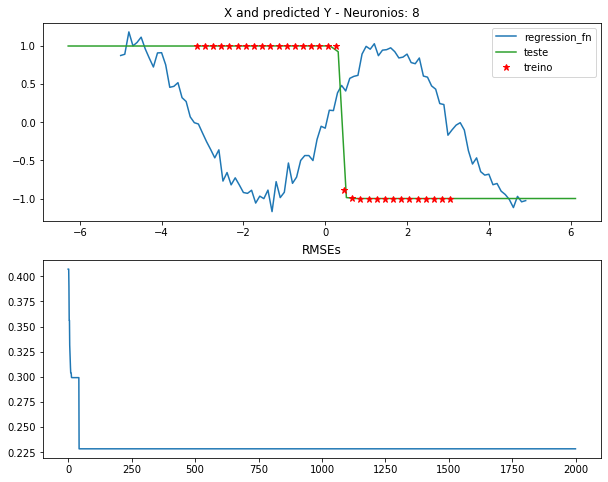

100%|██████████| 50/50 [00:00<00:00, 1923.18it/s]


first elite: 0.5162853056442157


  0%|          | 0/2000 [00:00<?, ?it/s]

0.3994779199892643 < 0.5162853056442157


  0%|          | 4/2000 [00:00<02:28, 13.42it/s]

0.33406278909632736 < 0.3994779199892643


  0%|          | 6/2000 [00:00<02:16, 14.64it/s]

0.3165947424121881 < 0.33406278909632736


  2%|▏         | 48/2000 [00:02<01:39, 19.57it/s]

0.29784079457476614 < 0.3165947424121881
0.28780785451809465 < 0.29784079457476614


  2%|▎         | 50/2000 [00:02<01:47, 18.10it/s]

0.27902262122498506 < 0.28780785451809465
0.23913044972373218 < 0.27902262122498506


  3%|▎         | 64/2000 [00:03<01:45, 18.39it/s]

0.2389512538049476 < 0.23913044972373218


  4%|▍         | 80/2000 [00:04<01:36, 19.82it/s]

0.238949879249206 < 0.2389512538049476


 10%|█         | 207/2000 [00:10<01:23, 21.55it/s]

0.23894987924920597 < 0.238949879249206


 10%|█         | 210/2000 [00:10<01:23, 21.33it/s]

0.23894987924920594 < 0.23894987924920597


 11%|█         | 222/2000 [00:11<01:32, 19.22it/s]

0.2389498792492059 < 0.23894987924920594


 11%|█▏        | 226/2000 [00:11<01:40, 17.57it/s]

0.23894987924920588 < 0.2389498792492059
0.23894987924920585 < 0.23894987924920588


 12%|█▏        | 237/2000 [00:12<01:34, 18.67it/s]

0.23894987924920583 < 0.23894987924920585


 21%|██        | 411/2000 [00:20<01:16, 20.74it/s]

0.23827058080157634 < 0.23894987924920583
0.22760505874000367 < 0.23827058080157634


 21%|██        | 418/2000 [00:21<01:31, 17.20it/s]

0.22736576251882562 < 0.22760505874000367


 21%|██        | 420/2000 [00:21<01:28, 17.94it/s]

0.22736241882577712 < 0.22736576251882562


 21%|██        | 422/2000 [00:21<01:33, 16.91it/s]

0.22695337679018898 < 0.22736241882577712


 21%|██        | 424/2000 [00:21<01:35, 16.46it/s]

0.22691898880295275 < 0.22695337679018898
0.22690591946197855 < 0.22691898880295275


 22%|██▏       | 430/2000 [00:22<01:35, 16.45it/s]

0.2268911744056918 < 0.22690591946197855


 22%|██▏       | 436/2000 [00:22<01:32, 16.99it/s]

0.22688758652320928 < 0.2268911744056918


 22%|██▏       | 440/2000 [00:22<01:31, 16.98it/s]

0.22168781887742317 < 0.22688758652320928


 22%|██▏       | 444/2000 [00:22<01:29, 17.38it/s]

0.22168599520529114 < 0.22168781887742317


 30%|███       | 606/2000 [00:31<01:09, 20.04it/s]

0.22168599520529111 < 0.22168599520529114


 30%|███       | 609/2000 [00:31<01:12, 19.11it/s]

0.2216859952052911 < 0.22168599520529111


 31%|███       | 616/2000 [00:32<01:17, 17.91it/s]

0.22168599520529106 < 0.2216859952052911


 31%|███       | 618/2000 [00:32<01:17, 17.91it/s]

0.22168599520529103 < 0.22168599520529106


 32%|███▏      | 645/2000 [00:33<01:07, 20.05it/s]

0.21986568905436854 < 0.22168599520529103


 34%|███▎      | 671/2000 [00:35<01:04, 20.71it/s]

0.218866768672699 < 0.21986568905436854
0.2175760419237637 < 0.218866768672699


 34%|███▎      | 674/2000 [00:35<01:06, 19.83it/s]

0.2174231916963685 < 0.2175760419237637


 34%|███▍      | 676/2000 [00:35<01:11, 18.50it/s]

0.2174094887435655 < 0.2174231916963685


 41%|████      | 818/2000 [00:42<00:56, 21.05it/s]

0.21740948874356547 < 0.2174094887435655


 41%|████▏     | 825/2000 [00:42<01:01, 19.17it/s]

0.21740948874356544 < 0.21740948874356547


 42%|████▏     | 833/2000 [00:43<01:04, 18.04it/s]

0.21740948874356542 < 0.21740948874356544


 76%|███████▌  | 1514/2000 [01:17<00:26, 18.16it/s]

0.21608378891694102 < 0.21740948874356542
0.2157123898317838 < 0.21608378891694102


 76%|███████▌  | 1516/2000 [01:17<00:31, 15.40it/s]

0.21555493512552534 < 0.2157123898317838


 84%|████████▍ | 1675/2000 [01:25<00:15, 20.77it/s]

0.21555493512552532 < 0.21555493512552534


 84%|████████▍ | 1684/2000 [01:25<00:16, 19.44it/s]

0.2155549351255253 < 0.21555493512552532


 84%|████████▍ | 1686/2000 [01:25<00:16, 19.06it/s]

0.21555493512552526 < 0.2155549351255253


 84%|████████▍ | 1688/2000 [01:26<00:17, 17.37it/s]

0.21555493512552523 < 0.21555493512552526


 93%|█████████▎| 1854/2000 [01:34<00:07, 18.55it/s]

0.20941381844528692 < 0.21555493512552523


 93%|█████████▎| 1857/2000 [01:35<00:07, 18.38it/s]

0.20936276849451635 < 0.20941381844528692


 94%|█████████▎| 1872/2000 [01:35<00:06, 19.09it/s]

0.20936104120575383 < 0.20936276849451635


 94%|█████████▍| 1881/2000 [01:36<00:06, 17.86it/s]

0.20935948541204072 < 0.20936104120575383


 94%|█████████▍| 1885/2000 [01:36<00:06, 18.33it/s]

0.2093594850294012 < 0.20935948541204072


 95%|█████████▍| 1891/2000 [01:36<00:05, 18.17it/s]

0.20935923311413404 < 0.2093594850294012


100%|██████████| 2000/2000 [01:42<00:00, 19.57it/s]


rmse Elite: 0.20935923311413404


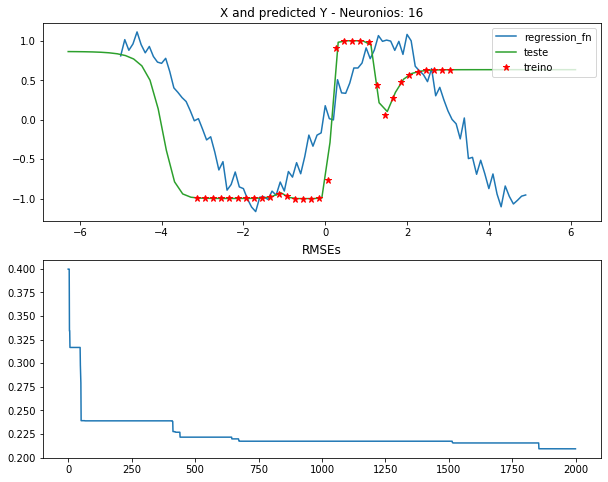

100%|██████████| 50/50 [00:00<00:00, 2499.41it/s]


first elite: 0.5094054725748359


  0%|          | 0/2000 [00:00<?, ?it/s]

0.4581886055443292 < 0.5094054725748359


  0%|          | 2/2000 [00:00<02:09, 15.38it/s]

0.4399115284081758 < 0.4581886055443292


  0%|          | 4/2000 [00:00<02:13, 14.99it/s]

0.413934528167656 < 0.4399115284081758


  0%|          | 10/2000 [00:00<02:08, 15.44it/s]

0.4084009421345048 < 0.413934528167656


  1%|          | 15/2000 [00:00<02:00, 16.44it/s]

0.40157769861017073 < 0.4084009421345048


  1%|          | 23/2000 [00:01<01:59, 16.59it/s]

0.3971829632096384 < 0.40157769861017073


  8%|▊         | 153/2000 [00:08<01:36, 19.14it/s]

0.3883343711086642 < 0.3971829632096384


  8%|▊         | 157/2000 [00:08<01:44, 17.58it/s]

0.38182852309164794 < 0.3883343711086642


  8%|▊         | 159/2000 [00:09<01:49, 16.82it/s]

0.3741709867138964 < 0.38182852309164794
0.3724457796804323 < 0.3741709867138964


  8%|▊         | 161/2000 [00:09<01:56, 15.85it/s]

0.37230407192787934 < 0.3724457796804323
0.37225754253615495 < 0.37230407192787934


  8%|▊         | 167/2000 [00:09<02:00, 15.17it/s]

0.37224611778768685 < 0.37225754253615495


  9%|▊         | 171/2000 [00:09<01:55, 15.78it/s]

0.3722171701203911 < 0.37224611778768685


  9%|▉         | 179/2000 [00:10<01:43, 17.61it/s]

0.3722139960122919 < 0.3722171701203911


  9%|▉         | 187/2000 [00:10<01:46, 16.97it/s]

0.37221362667767655 < 0.3722139960122919


 10%|▉         | 196/2000 [00:11<01:40, 17.99it/s]

0.37221359297467665 < 0.37221362667767655


 10%|█         | 200/2000 [00:11<01:49, 16.45it/s]

0.37221359084901395 < 0.37221359297467665


 10%|█         | 206/2000 [00:11<01:46, 16.89it/s]

0.3722135592681988 < 0.37221359084901395


 15%|█▌        | 303/2000 [00:16<01:25, 19.96it/s]

0.3446226141235859 < 0.3722135592681988


 17%|█▋        | 342/2000 [00:18<01:31, 18.15it/s]

0.32474150687449554 < 0.3446226141235859


 24%|██▍       | 475/2000 [00:26<01:18, 19.32it/s]

0.3052943647057396 < 0.32474150687449554


 24%|██▍       | 484/2000 [00:26<01:27, 17.40it/s]

0.26418019302859747 < 0.3052943647057396


 26%|██▌       | 517/2000 [00:28<01:18, 18.96it/s]

0.2641331422983561 < 0.26418019302859747


 67%|██████▋   | 1342/2000 [01:15<00:36, 18.18it/s]

0.25263848733830846 < 0.2641331422983561


 67%|██████▋   | 1344/2000 [01:15<00:35, 18.28it/s]

0.246838880576641 < 0.25263848733830846
0.24411834253178263 < 0.246838880576641


 67%|██████▋   | 1346/2000 [01:15<00:50, 12.96it/s]

0.22335956434975948 < 0.24411834253178263
0.22099232185462714 < 0.22335956434975948


 67%|██████▋   | 1348/2000 [01:15<00:57, 11.38it/s]

0.22091348579975548 < 0.22099232185462714


 68%|██████▊   | 1356/2000 [01:16<00:46, 13.90it/s]

0.2209035251099772 < 0.22091348579975548


 68%|██████▊   | 1358/2000 [01:16<00:43, 14.66it/s]

0.22084382929726873 < 0.2209035251099772


 75%|███████▍  | 1493/2000 [01:23<00:24, 20.98it/s]

0.21914282245326774 < 0.22084382929726873


 75%|███████▍  | 1496/2000 [01:23<00:28, 17.78it/s]

0.2189848457390344 < 0.21914282245326774


 75%|███████▍  | 1498/2000 [01:23<00:28, 17.45it/s]

0.2189706330030249 < 0.2189848457390344


 76%|███████▋  | 1526/2000 [01:25<00:24, 19.64it/s]

0.2189706034601133 < 0.2189706330030249


 78%|███████▊  | 1553/2000 [01:26<00:31, 14.25it/s]

0.21897060344948083 < 0.2189706034601133


 78%|███████▊  | 1565/2000 [01:27<00:35, 12.27it/s]

0.21897060344858638 < 0.21897060344948083


 81%|████████▏ | 1628/2000 [01:31<00:24, 15.34it/s]

0.21897060344858632 < 0.21897060344858638


 82%|████████▏ | 1630/2000 [01:31<00:24, 15.25it/s]

0.21897060344858627 < 0.21897060344858632


 82%|████████▏ | 1632/2000 [01:32<00:26, 13.71it/s]

0.2189706034485862 < 0.21897060344858627


 82%|████████▏ | 1634/2000 [01:32<00:27, 13.46it/s]

0.21897060344858613 < 0.2189706034485862


 82%|████████▏ | 1636/2000 [01:32<00:29, 12.28it/s]

0.21897060344858607 < 0.21897060344858613


 82%|████████▏ | 1638/2000 [01:32<00:31, 11.37it/s]

0.21897060344858602 < 0.21897060344858607
0.21897060344858596 < 0.21897060344858602


 82%|████████▏ | 1642/2000 [01:33<00:30, 11.59it/s]

0.21897060344858588 < 0.21897060344858596
0.2189706034485858 < 0.21897060344858588


 82%|████████▏ | 1644/2000 [01:33<00:29, 12.19it/s]

0.2189706034485857 < 0.2189706034485858


 82%|████████▏ | 1646/2000 [01:33<00:28, 12.51it/s]

0.21897060344858568 < 0.2189706034485857


 82%|████████▎ | 1650/2000 [01:33<00:29, 11.77it/s]

0.2189706034485856 < 0.21897060344858568
0.21897060344858554 < 0.2189706034485856


 83%|████████▎ | 1652/2000 [01:33<00:30, 11.50it/s]

0.21897060344858552 < 0.21897060344858554


 83%|████████▎ | 1654/2000 [01:34<00:29, 11.60it/s]

0.21897060344858546 < 0.21897060344858552


 83%|████████▎ | 1656/2000 [01:34<00:28, 12.09it/s]

0.21897060344858538 < 0.21897060344858546


 83%|████████▎ | 1658/2000 [01:34<00:28, 11.93it/s]

0.21897060344858535 < 0.21897060344858538
0.2189706034485853 < 0.21897060344858535


 83%|████████▎ | 1664/2000 [01:34<00:28, 11.81it/s]

0.21897060344858527 < 0.2189706034485853
0.21897060344858524 < 0.21897060344858527


 83%|████████▎ | 1668/2000 [01:35<00:27, 12.02it/s]

0.2189706034485852 < 0.21897060344858524


 86%|████████▌ | 1722/2000 [01:38<00:20, 13.51it/s]

0.2176542978162908 < 0.2189706034485852
0.21430972751812394 < 0.2176542978162908


 86%|████████▌ | 1724/2000 [01:39<00:23, 11.83it/s]

0.2140429166131733 < 0.21430972751812394
0.2140420750891893 < 0.2140429166131733


 86%|████████▋ | 1730/2000 [01:39<00:24, 10.99it/s]

0.21404179571528456 < 0.2140420750891893


 87%|████████▋ | 1736/2000 [01:40<00:24, 10.64it/s]

0.21404157544661576 < 0.21404179571528456


 87%|████████▋ | 1738/2000 [01:40<00:24, 10.48it/s]

0.21404156917641567 < 0.21404157544661576


 87%|████████▋ | 1742/2000 [01:40<00:25, 10.28it/s]

0.21404150928596227 < 0.21404156917641567


 92%|█████████▏| 1846/2000 [01:48<00:11, 13.32it/s]

0.20608553946400052 < 0.21404150928596227


 92%|█████████▏| 1848/2000 [01:49<00:11, 13.68it/s]

0.19346999811048007 < 0.20608553946400052


 92%|█████████▎| 1850/2000 [01:49<00:12, 12.01it/s]

0.19292069497535505 < 0.19346999811048007


 93%|█████████▎| 1854/2000 [01:49<00:12, 11.73it/s]

0.1923748704006587 < 0.19292069497535505


100%|█████████▉| 1992/2000 [01:56<00:00, 19.62it/s]

0.1923748704006586 < 0.1923748704006587


100%|██████████| 2000/2000 [01:57<00:00, 17.03it/s]


rmse Elite: 0.1923748704006586


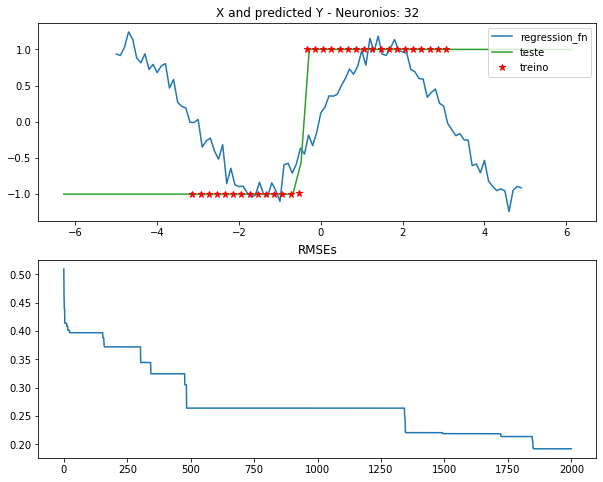

100%|██████████| 50/50 [00:00<00:00, 2083.55it/s]


first elite: 0.482540071596593


  0%|          | 2/2000 [00:00<02:51, 11.63it/s]

0.4132776988657705 < 0.482540071596593


  1%|          | 14/2000 [00:01<02:58, 11.12it/s]

0.4063416910590596 < 0.4132776988657705


  1%|          | 16/2000 [00:01<02:49, 11.71it/s]

0.4056131988554417 < 0.4063416910590596


  1%|          | 18/2000 [00:01<02:58, 11.10it/s]

0.39949911919677283 < 0.4056131988554417


  3%|▎         | 58/2000 [00:04<01:51, 17.39it/s]

0.38771344583818806 < 0.39949911919677283


  3%|▎         | 60/2000 [00:04<01:53, 17.04it/s]

0.3809442912778954 < 0.38771344583818806


  3%|▎         | 68/2000 [00:04<01:54, 16.92it/s]

0.3798480495801276 < 0.3809442912778954


 36%|███▋      | 726/2000 [00:43<01:16, 16.57it/s]

0.358100925343703 < 0.3798480495801276


 38%|███▊      | 764/2000 [00:46<01:18, 15.81it/s]

0.3289078129110677 < 0.358100925343703


 40%|████      | 806/2000 [00:49<01:40, 11.84it/s]

0.3283200384734495 < 0.3289078129110677


100%|██████████| 2000/2000 [02:03<00:00, 16.15it/s]


rmse Elite: 0.3283200384734495


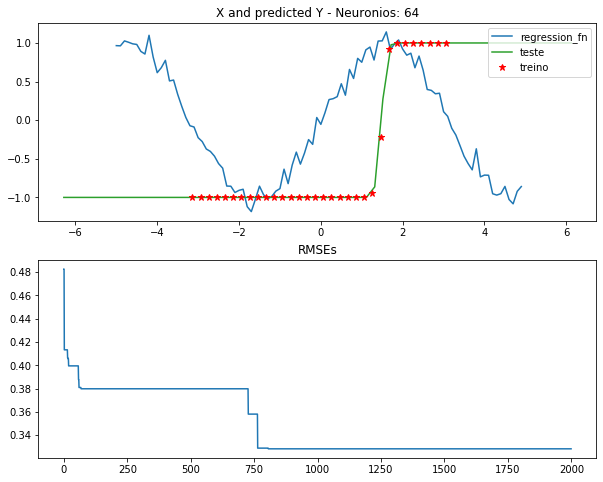

100%|██████████| 50/50 [00:00<00:00, 1428.56it/s]


first elite: 0.496074293943108


  0%|          | 1/2000 [00:00<05:03,  6.58it/s]

0.48951113834676047 < 0.496074293943108


  0%|          | 3/2000 [00:00<04:25,  7.52it/s]

0.42101414080058286 < 0.48951113834676047


  1%|          | 17/2000 [00:01<02:22, 13.89it/s]

0.39350367064209707 < 0.42101414080058286


  1%|▏         | 25/2000 [00:01<02:20, 14.10it/s]

0.384780671780548 < 0.39350367064209707


  1%|▏         | 27/2000 [00:02<02:19, 14.17it/s]

0.3815386893291175 < 0.384780671780548


  1%|▏         | 29/2000 [00:02<02:29, 13.22it/s]

0.3815274905092153 < 0.3815386893291175


  2%|▏         | 39/2000 [00:03<02:21, 13.89it/s]

0.3815046185012749 < 0.3815274905092153


 10%|▉         | 191/2000 [00:13<02:06, 14.33it/s]

0.38150461850127476 < 0.3815046185012749


 10%|█         | 203/2000 [00:14<02:05, 14.34it/s]

0.3815046185012747 < 0.38150461850127476


 11%|█         | 213/2000 [00:15<02:02, 14.56it/s]

0.3764668609764682 < 0.3815046185012747


 19%|█▉        | 389/2000 [00:27<01:50, 14.64it/s]

0.37646686097646814 < 0.3764668609764682


 25%|██▍       | 491/2000 [00:34<01:39, 15.10it/s]

0.32681801583972425 < 0.37646686097646814


 33%|███▎      | 659/2000 [00:46<01:29, 14.93it/s]

0.3268180158397241 < 0.32681801583972425


 33%|███▎      | 663/2000 [00:46<01:39, 13.50it/s]

0.32681801583972403 < 0.3268180158397241


 33%|███▎      | 665/2000 [00:47<01:39, 13.48it/s]

0.32681801583972375 < 0.32681801583972403


 33%|███▎      | 669/2000 [00:47<01:39, 13.43it/s]

0.3268180158397237 < 0.32681801583972375


 34%|███▎      | 673/2000 [00:47<01:46, 12.48it/s]

0.32681801583972364 < 0.3268180158397237


 34%|███▍      | 675/2000 [00:47<01:54, 11.57it/s]

0.3268180158397236 < 0.32681801583972364
0.32681801583972353 < 0.3268180158397236


 34%|███▍      | 677/2000 [00:48<02:08, 10.32it/s]

0.3268180158397235 < 0.32681801583972353
0.32681801583972336 < 0.3268180158397235


 34%|███▍      | 683/2000 [00:48<02:20,  9.36it/s]

0.3268180158397233 < 0.32681801583972336


 34%|███▍      | 685/2000 [00:49<02:11, 10.00it/s]

0.32681801583972325 < 0.3268180158397233


 37%|███▋      | 739/2000 [00:53<01:57, 10.75it/s]

0.32118349405238966 < 0.32681801583972325


 37%|███▋      | 745/2000 [00:53<01:59, 10.50it/s]

0.32083122271128983 < 0.32118349405238966


 37%|███▋      | 747/2000 [00:53<01:59, 10.46it/s]

0.32060236092961786 < 0.32083122271128983


 38%|███▊      | 755/2000 [00:54<01:57, 10.59it/s]

0.3205807258026982 < 0.32060236092961786


 39%|███▉      | 787/2000 [00:57<01:41, 11.89it/s]

0.32058072285280936 < 0.3205807258026982


 40%|████      | 803/2000 [00:58<01:35, 12.51it/s]

0.3205807226488914 < 0.32058072285280936


 44%|████▍     | 889/2000 [01:04<01:24, 13.20it/s]

0.32058072264889137 < 0.3205807226488914


 45%|████▍     | 891/2000 [01:04<01:35, 11.62it/s]

0.3205807226488913 < 0.32058072264889137


 45%|████▍     | 893/2000 [01:05<01:34, 11.69it/s]

0.32058072264889126 < 0.3205807226488913


 45%|████▍     | 895/2000 [01:05<01:37, 11.37it/s]

0.3205807226488911 < 0.32058072264889126


 45%|████▍     | 897/2000 [01:05<01:34, 11.71it/s]

0.32058072264889104 < 0.3205807226488911


 45%|████▍     | 899/2000 [01:05<01:41, 10.79it/s]

0.320580722648891 < 0.32058072264889104


 45%|████▌     | 901/2000 [01:05<01:36, 11.43it/s]

0.3205807226488909 < 0.320580722648891


 45%|████▌     | 905/2000 [01:06<01:29, 12.24it/s]

0.32058072264889087 < 0.3205807226488909
0.3205807226488908 < 0.32058072264889087


 46%|████▌     | 915/2000 [01:06<01:19, 13.71it/s]

0.32058072264889076 < 0.3205807226488908


 46%|████▋     | 927/2000 [01:07<01:14, 14.44it/s]

0.3205807226488907 < 0.32058072264889076


 57%|█████▋    | 1147/2000 [01:22<00:57, 14.78it/s]

0.3195795640852998 < 0.3205807226488907


 58%|█████▊    | 1151/2000 [01:23<01:02, 13.53it/s]

0.3180721609819547 < 0.3195795640852998
0.3174449652273267 < 0.3180721609819547


 58%|█████▊    | 1153/2000 [01:23<01:05, 12.99it/s]

0.31696803168144105 < 0.3174449652273267


 65%|██████▍   | 1297/2000 [01:33<00:46, 15.14it/s]

0.316968031681441 < 0.31696803168144105


 65%|██████▍   | 1299/2000 [01:33<00:46, 15.22it/s]

0.3169680316814409 < 0.316968031681441


 65%|██████▌   | 1301/2000 [01:33<00:51, 13.51it/s]

0.3169680316814408 < 0.3169680316814409


 65%|██████▌   | 1307/2000 [01:34<00:53, 13.03it/s]

0.3169680316814407 < 0.3169680316814408


 66%|██████▌   | 1321/2000 [01:35<00:47, 14.41it/s]

0.31696803168144067 < 0.3169680316814407


 66%|██████▋   | 1325/2000 [01:35<00:48, 13.78it/s]

0.3169680316814406 < 0.31696803168144067


 72%|███████▏  | 1431/2000 [01:43<00:39, 14.25it/s]

0.3157813356072651 < 0.3169680316814406


 72%|███████▏  | 1433/2000 [01:43<00:41, 13.54it/s]

0.26586044996523595 < 0.3157813356072651


 72%|███████▏  | 1435/2000 [01:43<00:42, 13.39it/s]

0.2658250203408768 < 0.26586044996523595


 72%|███████▏  | 1437/2000 [01:43<00:41, 13.50it/s]

0.2631310537005974 < 0.2658250203408768


 72%|███████▏  | 1439/2000 [01:43<00:46, 11.98it/s]

0.26255054752721013 < 0.2631310537005974


 79%|███████▉  | 1583/2000 [01:53<00:27, 15.01it/s]

0.2625505475272101 < 0.26255054752721013


 79%|███████▉  | 1587/2000 [01:53<00:31, 13.02it/s]

0.26255054752720997 < 0.2625505475272101


 80%|████████  | 1601/2000 [01:54<00:27, 14.44it/s]

0.26255054752720985 < 0.26255054752720997


 81%|████████  | 1613/2000 [01:55<00:27, 14.18it/s]

0.2625505475272098 < 0.26255054752720985


100%|██████████| 2000/2000 [02:23<00:00, 13.92it/s]


rmse Elite: 0.2625505475272098


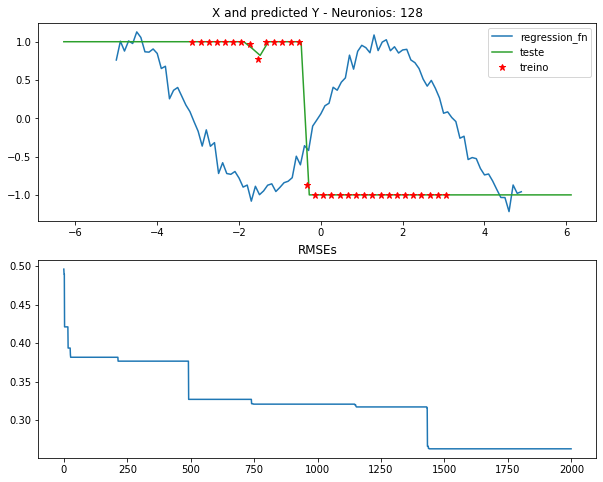

TABELA DE RMSEs
   qntNeuronios  rmseTreio  rmseTeste
0             2   0.236733   1.190147
1             4   0.232766   1.167354
2             8   0.228505   1.213225
3            16   0.209359   0.814223
4            32   0.192375   1.234422
5            64   0.328320   1.334687
6           128   0.262551   1.210670


In [5]:
tabelaRmse = []
class individuo():
    def __init__(self,rede,aptidao):
        self.gene = rede
        self.aptidao = aptidao
    
    def toPrint(self):
        print("<><><><>\ngene:")
        for layer in self.gene:
            print("pesos:")
            print(layer.weights)
            print("biases:")
            print(layer.biases)
        print("aptidao:",self.aptidao)

        
def find_best_individual(populacao):
    bestSheep = populacao[0]
    for ind in populacao:
        if ind.aptidao < bestSheep.aptidao:
            bestSheep = ind
            
    return deepcopy(bestSheep)
        

def selection_and_crossover(populacao):
    # pega 2 individuos aleatorios
    # para cada individuo procura um oponente de forma aleatoria
    # gera 2 duelos, os vencedores se copulam
    # populaçao mais forte gerada
    strongPopulation = []
    for _ in range(len(populacao)//2):
        casalForte = []
        ind1 = populacao[np.random.randint(0,len(populacao))]
        ind2 = populacao[np.random.randint(0,len(populacao))]
        
        opo1 = populacao[np.random.randint(0,len(populacao))]
        opo2 = populacao[np.random.randint(0,len(populacao))]
        
        #garantir que nao sao a mesmas pessoas lutando entre si
        while ind2 is ind1:
#             print("1",ind1.aptidao,ind2.aptidao)
            ind2 = populacao[np.random.randint(0,len(populacao))]           
        while opo1 is ind1 or opo1 is ind2:
#             print("2",ind1.aptidao,opo1.aptidao)
            opo1 = populacao[np.random.randint(0,len(populacao))]           
        while opo2 is opo1 or opo2 is ind2 or opo2 is ind1:
#             print("3",ind2.aptidao,opo2.aptidao)
            opo2 = populacao[np.random.randint(0,len(populacao))]
            
        #tournament
        if ind1.aptidao < opo1.aptidao:
            casalForte.append(ind1)
        else:
            casalForte.append(opo1)
            
        if ind2.aptidao < opo2.aptidao:
            casalForte.append(ind2)
        else:
            casalForte.append(opo2)
        
        sons = crossOver(casalForte[0],casalForte[1])
        
        for s in sons:
            strongPopulation.append(deepcopy(s))
    
    return strongPopulation
        
        
def crossOver(individuo1,individuo2):
    ind1 = deepcopy(individuo1)
    ind2 = deepcopy(individuo2)
    c1 = deepcopy(individuo1)
    c2 = deepcopy(individuo2)
    for i in range(len(individuo1.gene)): # tamanho de camadas da rede
        peso1 = ind1.gene[i].weights # matriz de peso
        peso2 = ind2.gene[i].weights
        biases1 = ind1.gene[i].biases # vetor de peso
        biases2 = ind2.gene[i].biases
        
        A = random.uniform(0,1)
        c1.gene[i].weights = A*peso1+(1-A)*peso2 # cruzando matriz peso
        c2.gene[i].weights = A*peso2+(1-A)*peso1
        c1.gene[i].biases = A*biases1+(1-A)*biases2 # cruzando vetor de biases
        c2.gene[i].biases = A*biases2+(1-A)*biases1
        
        c1.aptidao = calculaRMSE(TREINO_ESCOPO,RESP_regression,c1.gene)
        c2.aptidao = calculaRMSE(TREINO_ESCOPO,RESP_regression,c2.gene)
    
    return [c1,c2]

def mutation(populacao):
    for ind in populacao:
        chance = np.random.randint(0, 100)
        if chance <= 10:
#             print ("antes mutaçao ")
#             ind.toPrint()
            rede = []
            inLayer = 1
            for i in range(len(ind.gene)):
                outLayer = len(ind.gene[i].biases)
                rede.append(Camada(inLayer,outLayer))
                inLayer = outLayer
#             rede.append(Camada(inLayer,1))
            #novo genoma
            aptidao = calculaRMSE(TREINO_ESCOPO,RESP_regression,rede)
#             print("Depois mutaçao")
            populacao.remove(ind)
            newInd = individuo(rede,aptidao)
#             newInd.toPrint()
            populacao.append(newInd)
            
            #novo individuo
            
#             #print("mutation TIMES")
#             isPeso = False
#             rede = deepcopy(ind.gene)
#             # pega um peso/bias aleatorio
#             layerId = np.random.randint(len(rede))
#             weighId = np.random.randint(len(rede[layerId].weights))
#             neuroId = np.random.randint(len(rede[layerId].weights[weighId]))

#             # extraindo peso e bias
#             peso = rede[layerId].weights[weighId][neuroId]
#             bias = rede[layerId].biases[neuroId]

#             # filtro para mudar Peso ou Bias
#             if random.uniform(0,1) <= 0.5:
#                 isPeso = True
#                 data = peso
#             else:
#                 isPeso = False
#                 data = bias

#             if random.uniform(0,1) <= 0.5:
#                 newdata = data + np.random.normal(loc=0, scale=DESVIO_PADRAO)
#                 #adiciona gaussiana no dado
#                 # basicamente vai pegar outro vizinho enquanto estiver fora do espaço de busca
# #                 print("newdata:",newdata)
#                 while newdata < SEARCH_SPACE[0] or newdata > SEARCH_SPACE[1]:
#                     ruido = abs(np.random.normal(loc=0, scale=DESVIO_PADRAO))
#                     if newdata < SEARCH_SPACE[0]:
#                         ruido = ruido
#                     if newdata > SEARCH_SPACE[1]:
#                         ruido = - ruido
#                     newdata = newdata + ruido
# #                     print("newdata:",newdata)
#             else:
#                 newdata = np.random.uniform(SEARCH_SPACE[0], SEARCH_SPACE[1])
#                 #muda o dado para um valor aleatorio dentro do espaço de busca


#             if isPeso:
#                 rede[layerId].weights[weighId][neuroId] = newdata
#             else:
#                 rede[layerId].biases[neuroId] = newdata

#             ind.genes = deepcopy(rede) #vias das duvidas
#             ind.aptidao = calculaRMSE(TREINO_ESCOPO,RESP_regression,rede)

    return populacao

def calc_aptidao(populacao,TREINO_ESCOPO,RESP_regression):
    for ind in populacao:
        ind.aptidao = calculaRMSE(TREINO_ESCOPO,RESP_regression,ind.gene)
    return populacao

def elitism(populacao,elite):
    blackSheep = populacao[0]
    bestSheep = populacao[0]
    for ind in populacao:
        if ind.aptidao > blackSheep.aptidao:
            blackSheep = ind
        if ind.aptidao < bestSheep.aptidao:
            bestSheep = ind
            
    if bestSheep.aptidao <= elite.aptidao:
        return populacao
    else:
        populacao.remove(blackSheep)
        populacao.append(elite)
#         print(len(populacao))
                
        return populacao

def printpop(populacao):
    for ind in populacao:
        print(ind.aptidao)
    
def main():
    
    entrada = [0]
    tabelaNeural = [0]
    tabelaNeural = [2,4,8,16,32,64,128]
    
    
    if len(tabelaNeural) == 1:
        print("Quantas camadas você deseja que a rede tenha?")
        camadas = int(input()) # quantas camadas vc quer
        for i in range(camadas):
            print("Quantos neuronios na camada",i,"voce deseja?")
            outLayer = int(input()) # quantos neuronios vc quer
            tabelaNeural.append(outLayer)
    else:
        camadas = 1    

    for tn in range(len(tabelaNeural)):
        populacao = []
        RMSEs = []
        
        #Cria a populaçao
        for i in tqdm.tqdm(range(N_POPULACAO)):
            rede = []
            inLayer = len(entrada)
            for i in range(camadas):
                outLayer = tabelaNeural[tn]
                rede.append(Camada(inLayer,outLayer))
                inLayer = outLayer
            rede.append(Camada(inLayer,len(entrada)))
            #fez a rede
            aptidao = calculaRMSE(TREINO_ESCOPO,RESP_regression,rede)
            populacao.append(individuo(rede,aptidao))
            
        
        elite = find_best_individual(populacao)
        rmse = elite.aptidao
        print("first elite:",rmse)
        for _ in tqdm.tqdm(range(N_INTERACAO)):
            populacao = selection_and_crossover(populacao)
            populacao = mutation(populacao)
#             populacao = calc_aptidao(populacao,TREINO_ESCOPO,RESP_regression)
            populacao = elitism(populacao,elite)
            elite = find_best_individual(populacao)
            
#             printpop(populacao)
            if elite.aptidao < rmse:
                print(elite.aptidao,"<",rmse)
            
            
            rmse = elite.aptidao
            RMSEs.append(rmse)
            
        print("rmse Elite:",elite.aptidao)
        
        resultado_teste = []

        resultado_treino=[]
        for te in TREINO_ESCOPO:
            resultado_treino.append(processNN([te],rede)[0])
        
        for te in TESTE_ESCOPO:
            resultado_teste.append(processNN([te],rede)[0])
        
        rmseTeste = calculaRMSE(TESTE_ESCOPO,RESP_regression_teste,rede)
            
    
        # adiciona o Rmse final a tabela 
        tabelaRmse.append([tabelaNeural[tn], rmse,rmseTeste])
        
        
        # plota o conjunto de treinamento + conjunto de teste
        figure= plt.subplots(figsize=(10, 8))
        plt.title("RMSE", fontsize=20)
        plt.xlabel("interacoes")
        plt.ylabel("Fo")
        plt.subplot(2, 1, 1)
        plt.cla()
        plot_fn(true_regression_fn, SEARCH_SPACE)
        plot_teste = plt.plot(TESTE_ESCOPO, resultado_teste,color='tab:green', markersize=7, label="teste") # resposta da rede com o escopo de teste
        plot_treino = plt.plot(TREINO_ESCOPO, resultado_treino,'*r', markersize=7, label = "treino") # resposta da rede com o escopo de treino
        #plt.legend(handles=[plot_teste, plot_treino])plt.plot(X_teste, y_teste ,'o', label='Teste')
        plt.legend(loc ="upper right")
        plt.title("X and predicted Y - Neuronios: "+str(tabelaNeural[tn]))
        

        plt.subplot(2, 1, 2)
        # plta o avanço do rmse 
        plt.title("RMSEs")
        plt.plot(RMSEs)
        plt.show()

        
    #printa a tabela
    print("TABELA DE RMSEs")
    print(pd.DataFrame(tabelaRmse, columns=["qntNeuronios", "rmseTreio","rmseTeste"]))
    

if __name__ == "__main__":
    main()